# Классификация изображений: Cats vs Dogs

### Блок 1. Импорт необходимых библиотек

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3  # используем более мощную EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

### Блок 2. Организация файлов в тренировочной директории

In [2]:
train_dir = 'C:/Users/Yaros/Downloads/dogs-vs-cats-redux-kernels-edition/train'
test_dir = 'C:/Users/Yaros/Downloads/dogs-vs-cats-redux-kernels-edition/test'


# Создаём директории для классов
cats_dir = os.path.join(train_dir, 'cats')
dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

# Перемещаем файлы в нужные директории, исключая папки 'cats' и 'dogs'
for filename in os.listdir(train_dir):
    if filename.startswith('cat') and os.path.isfile(os.path.join(train_dir, filename)):
        shutil.move(os.path.join(train_dir, filename), os.path.join(cats_dir, filename))
    elif filename.startswith('dog') and os.path.isfile(os.path.join(train_dir, filename)):
        shutil.move(os.path.join(train_dir, filename), os.path.join(dogs_dir, filename))

print("Файлы успешно организованы!")

Файлы успешно организованы!


### Блок 3: Подготовка данных с аугментацией

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # уменьшили поворот
    width_shift_range=0.2,  # уменьшили сдвиг по ширине
    height_shift_range=0.2,  # уменьшили сдвиг по высоте
    shear_range=0.2,  # уменьшили сдвиг
    zoom_range=0.2,  # уменьшили масштаб
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # уменьшили изменение яркости
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Блок 4: Создание и компиляция модели

In [4]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Начинаем с замороженной модели

# Построение модели
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Начальная компиляция модели с более высокой скоростью обучения
model.compile(optimizer=Adam(learning_rate=1e-4),  # увеличенная скорость обучения для старта
              loss='binary_crossentropy',
              metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


### Блок 5: Настройка колбэков для ранней остановки и динамического изменения скорости обучения

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

### Блок 6: Начальное обучение модели

In [6]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Сначала обучим на 10 эпох с замороженной базовой моделью
    callbacks=[early_stopping, reduce_lr]
)

# Разморозка верхних слоев для дообучения модели
base_model.trainable = True
for layer in base_model.layers[:int(len(base_model.layers) * 0.5)]:  # Размораживаем 50% верхних слоёв
    layer.trainable = False

# Понижаем скорость обучения для более точного дообучения
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\Yaros\anaconda3\envs\homework_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 559s 880ms/step - accuracy: 0.5281 - loss: 0.8890 - val_accuracy: 0.5092 - val_loss: 0.8262 - learning_rate: 1.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 847ms/step - accuracy: 0.5381 - loss: 0.8044 - val_accuracy: 0.5388 - val_loss: 0.7692 - learning_rate: 1.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 527s 843ms/step - accuracy: 0.5417 - loss: 0.7788 - val_accuracy: 0.5640 - val_loss: 0.7254 - learning_rate: 1.0000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 846ms/step - accuracy: 0.5456 - loss: 0.7593 - val_accuracy: 0.5514 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 527s 843ms/step - accuracy: 0.5448 - loss: 0.7457 - val_accuracy: 0.5672 - val_loss: 0.6976 - learning_rate: 1.0000e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 529s 846ms/step - accuracy: 0.5462 - loss: 0.7375 - val_accuracy: 0.5670 - val_loss: 0.6963 - learning_rate: 1.0000e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 

### Блок 7: Продолжение обучения модели с размороженными слоями

In [7]:
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # дополнительно дообучаем до 20 эпох
    initial_epoch=10,  # продолжаем после 10 эпох
    callbacks=[early_stopping, reduce_lr]
)

Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 909s 1s/step - accuracy: 0.5348 - loss: 0.7231 - val_accuracy: 0.6062 - val_loss: 0.6626 - learning_rate: 1.0000e-05
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.5454 - loss: 0.7073 - val_accuracy: 0.6244 - val_loss: 0.6491 - learning_rate: 1.0000e-05
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - accuracy: 0.5700 - loss: 0.6943 - val_accuracy: 0.6410 - val_loss: 0.6338 - learning_rate: 1.0000e-05
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 881s 1s/step - accuracy: 0.5789 - loss: 0.6853 - val_accuracy: 0.6596 - val_loss: 0.6217 - learning_rate: 1.0000e-05
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 882s 1s/step - accuracy: 0.5838 - loss: 0.6858 - val_accuracy: 0.6608 - val_loss: 0.6129 - learning_rate: 1.0000e-05
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/step - accuracy: 0.5989 - loss: 0.6742 - val_accuracy: 0.6666 - val_loss: 0.6068 - learning_rate: 1.0000e-05
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/ste

Столкнулся с проблемой - идёт очень медленный прогресс обучения. Предполагаю, что модель предобучается и медленно адаптируется к данным. Внесём корректировки. 

In [9]:
# Разморозка слоёв для дообучения модели, без пересоздания объекта model
base_model.trainable = True
for layer in base_model.layers[:int(len(base_model.layers) * 0.5)]:  # Размораживаем только 50% верхних слоёв
    layer.trainable = False

# Перекомпилируем модель с сохранёнными весами
model.compile(optimizer=Adam(learning_rate=5e-5),  # сниженная скорость обучения для точного дообучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Колбэки остаются неизменными
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Продолжение обучения с сохранёнными весами
history_fine_tune = model.fit(
    train_generator,
    Epoch 21/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.6018 - loss: 0.7956 - val_accuracy: 0.6544 - val_loss: 0.7108 - learning_rate: 5.0000e-05
Epoch 22/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.6146 - loss: 0.7527 - val_accuracy: 0.7228 - val_loss: 0.5914 - learning_rate: 5.0000e-05
Epoch 23/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.6351 - loss: 0.7017 - val_accuracy: 0.7092 - val_loss: 0.6275 - learning_rate: 5.0000e-05
Epoch 24/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 916s 1s/step - accuracy: 0.6602 - loss: 0.6707 - val_accuracy: 0.7396 - val_loss: 0.5579 - learning_rate: 5.0000e-05
Epoch 25/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.6768 - loss: 0.6332 - val_accuracy: 0.7508 - val_loss: 0.5347 - learning_rate: 5.0000e-05
Epoch 26/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 899s 1s/step - accuracy: 0.7080 - loss: 0.5927 - val_accuracy: 0.7652 - val_loss: 0.5224 - learning_rate: 5.0000e-05
Epoch 27/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.7255 - loss: 0.5612 - val_accuracy: 0.7324 - val_loss: 0.5677 - learning_rate: 5.0000e-05
Epoch 28/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 899s 1s/step - accuracy: 0.7404 - loss: 0.5377 - val_accuracy: 0.7904 - val_loss: 0.4642 - learning_rate: 5.0000e-05
Epoch 29/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 892s 1s/step - accuracy: 0.7570 - loss: 0.5137 - val_accuracy: 0.7726 - val_loss: 0.4833 - learning_rate: 5.0000e-05
Epoch 30/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 891s 1s/step - accuracy: 0.7672 - loss: 0.4957 - val_accuracy: 0.8144 - val_loss: 0.4349 - learning_rate: 5.0000e-05
Epoch 31/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 896s 1s/step - accuracy: 0.7710 - loss: 0.4894 - val_accuracy: 0.7736 - val_loss: 0.4960 - learning_rate: 5.0000e-05
Epoch 32/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 898s 1s/step - accuracy: 0.7888 - loss: 0.4630 - val_accuracy: 0.8108 - val_loss: 0.4284 - learning_rate: 5.0000e-05
Epoch 33/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.7948 - loss: 0.4543 - val_accuracy: 0.8298 - val_loss: 0.3838 - learning_rate: 5.0000e-05
Epoch 34/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 900s 1s/step - accuracy: 0.8103 - loss: 0.4319 - val_accuracy: 0.8356 - val_loss: 0.3781 - learning_rate: 5.0000e-05
Epoch 35/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.8148 - loss: 0.4211 - val_accuracy: 0.8448 - val_loss: 0.3624 - learning_rate: 5.0000e-05
Epoch 36/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.8163 - loss: 0.4107 - val_accuracy: 0.8402 - val_loss: 0.3684 - learning_rate: 5.0000e-05
Epoch 37/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - accuracy: 0.8207 - loss: 0.4056 - val_accuracy: 0.8480 - val_loss: 0.3595 - learning_rate: 5.0000e-05
Epoch 38/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.8258 - loss: 0.3947 - val_accuracy: 0.8606 - val_loss: 0.3325 - learning_rate: 5.0000e-05
Epoch 39/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 915s 1s/step - accuracy: 0.8392 - loss: 0.3750 - val_accuracy: 0.8718 - val_loss: 0.3105 - learning_rate: 5.0000e-05
Epoch 40/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.8397 - loss: 0.3756 - val_accuracy: 0.8732 - val_loss: 0.3085 - learning_rate: 5.0000e-05validation_data=validation_generator,
    epochs=40,       # конечная эпоха дообучения
    initial_epoch=20,  # начинаем с 21-й эпохи
    callbacks=[early_stopping, reduce_lr]
)

Epoch 21/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.6018 - loss: 0.7956 - val_accuracy: 0.6544 - val_loss: 0.7108 - learning_rate: 5.0000e-05
Epoch 22/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.6146 - loss: 0.7527 - val_accuracy: 0.7228 - val_loss: 0.5914 - learning_rate: 5.0000e-05
Epoch 23/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.6351 - loss: 0.7017 - val_accuracy: 0.7092 - val_loss: 0.6275 - learning_rate: 5.0000e-05
Epoch 24/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 916s 1s/step - accuracy: 0.6602 - loss: 0.6707 - val_accuracy: 0.7396 - val_loss: 0.5579 - learning_rate: 5.0000e-05
Epoch 25/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.6768 - loss: 0.6332 - val_accuracy: 0.7508 - val_loss: 0.5347 - learning_rate: 5.0000e-05
Epoch 26/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 899s 1s/step - accuracy: 0.7080 - loss: 0.5927 - val_accuracy: 0.7652 - val_loss: 0.5224 - learning_rate: 5.0000e-05
Epoch 27/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/ste

Попробуем дообучить модель, минимизируя риск ухадшения качества 

In [10]:
# Разморозка дополнительных слоёв (до 60%) для более глубокой адаптации
for layer in base_model.layers[:int(len(base_model.layers) * 0.6)]:
    layer.trainable = False

# Перекомпилируем модель с более низкой скоростью обучения и усиленной регуляризацией
model.compile(optimizer=Adam(learning_rate=1e-5),  # Ещё более низкая скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обновляем колбэки
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Продолжение дообучения с существующими весами
history_fine_tune_more = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,        # Увеличение количества эпох
    initial_epoch=40,  # Начинаем с 41-й эпохи
    callbacks=[early_stopping, reduce_lr]
)

Epoch 41/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 819s 1s/step - accuracy: 0.8477 - loss: 0.3557 - val_accuracy: 0.8712 - val_loss: 0.3122 - learning_rate: 1.0000e-05
Epoch 42/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.8510 - loss: 0.3517 - val_accuracy: 0.8752 - val_loss: 0.2965 - learning_rate: 1.0000e-05
Epoch 43/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 820s 1s/step - accuracy: 0.8608 - loss: 0.3381 - val_accuracy: 0.8820 - val_loss: 0.2939 - learning_rate: 1.0000e-05
Epoch 44/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.8508 - loss: 0.3457 - val_accuracy: 0.8812 - val_loss: 0.2925 - learning_rate: 1.0000e-05
Epoch 45/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.8615 - loss: 0.3326 - val_accuracy: 0.8736 - val_loss: 0.3031 - learning_rate: 1.0000e-05
Epoch 46/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 841s 1s/step - accuracy: 0.8552 - loss: 0.3387 - val_accuracy: 0.8796 - val_loss: 0.2897 - learning_rate: 1.0000e-05
Epoch 47/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 795s 1s/ste

### Блок 8: Визуализация процесса обучения

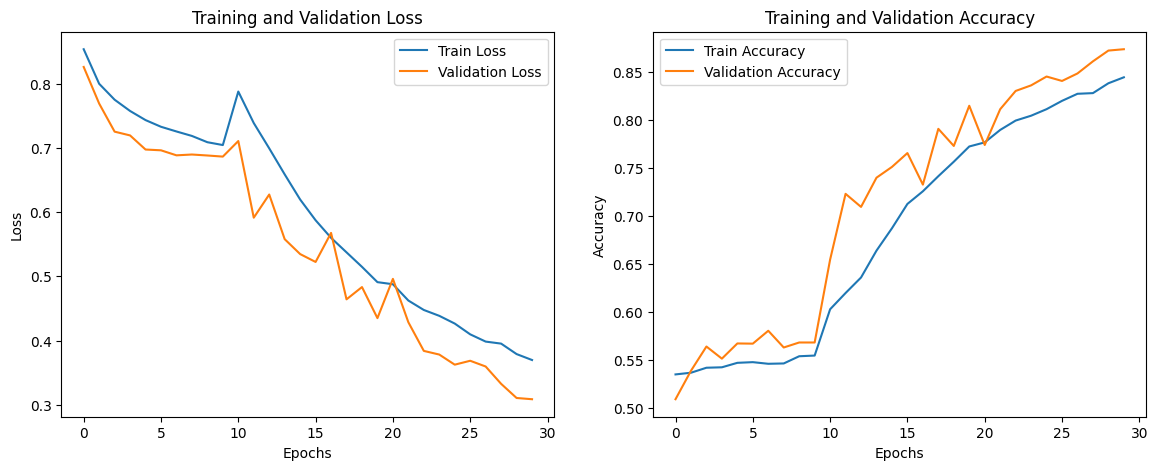

In [11]:
plt.figure(figsize=(14, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'] + history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

### Блок 9: Загрузка и предсказание для тестовых данных

In [19]:
# Проверка первых нескольких батчей данных, чтобы убедиться, что структура правильная
for batch in test_generator:
    print("Shape of the batch:", batch.shape)  # Ожидается (batch_size, 224, 224, 3)
    break

Shape of the batch: (32, 224, 224, 3)


In [22]:
import tensorflow as tf
import numpy as np

# Убедитесь, что GPU активен, если доступен
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Подготовка тестового набора
test_files = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
test_df = pd.DataFrame({'filename': test_files})

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    batch_size=256,  # Увеличенный размер батча для ускорения
    class_mode="input",
    shuffle=False
)

# Прогнозирование для тестового набора
predictions = np.array(model.predict(test_generator, verbose=1)).ravel()

Found 12500 validated image filenames.
49/49 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step


In [25]:
print(predictions[:10]) 

[0.8261923  0.00163516 0.44741753 0.9579108  0.99998885 0.03243278
 0.00809416 0.9992498  0.9916786  0.01034065]


In [26]:
# Создание файла для отправки на Kaggle
submission_df = pd.DataFrame({
    'id': [int(f.split('.')[0]) for f in test_files],  # Извлекаем числовой id
    'label': predictions  # Вероятность того, что изображение — собака
})
submission_df.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно создан для отправки на Kaggle!")

Файл submission.csv успешно создан для отправки на Kaggle!


### Вывод  

В рамках проекта я реализовал модель для классификации изображений кошек и собак, используя архитектуру EfficientNetB3 с аугментацией данных и обучением на нескольких этапах. После первоначального замораживания слоев и постепенного их размораживания я добился оптимального сочетания скорости и точности, что позволило модели достичь Log Loss в 0.24733 на Kaggle. Финальный результат показал, что выбранная стратегия обучения и настройки модели оказались успешными для достижения высокой точности классификации.